# Causal Estimate with Do-Calculus

In [1]:
# Run with Python 3
# Do Why library: https://github.com/microsoft/dowhy

In [2]:
import random
import numpy as np

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import dowhy
from dowhy.do_why import CausalModel
from IPython.display import Image, display

### Data Simulation

In [3]:
def get_samples(N=1000):
    
    data = []
    
    for i in range(N):
        age_under30 = random.randint(0,1)
        time_morning = random.randint(0,1)
        platform_1 = random.randint(0,1)

        # if the platform is platform_1, the ad_1 is more likely
        if platform_1:
            ad_1 = np.random.choice([0,1], p=[0.7, 0.3])
        else:
            ad_1 = np.random.choice([0,1], p=[0.3, 0.7])

        # positive effect of ad_1 on click through rate
        y_temp = age_under30 + time_morning + platform_1 + 5*ad_1
        y = int(round((1 / (1 + np.exp(-y_temp)))*2-1))  # round logistic to nearest integer

        data.append([age_under30, time_morning, platform_1, ad_1, y])
    
    return data

In [4]:
raw_data = get_samples(N=100)
data = pd.DataFrame(raw_data, columns=['age_under30', 'time_morning', 'platform_1', 'ad_1', 'y'])

In [5]:
data.head()

,age_under30,time_morning,platform_1,ad_1,y
0,0,1,0,0,0
1,1,0,1,1,1
2,0,1,1,0,1
3,0,0,1,0,0
4,0,1,0,1,1


### Model

INFO:dowhy.do_why:Model to find the causal effect of treatment ['ad_1'] on outcome ['y']


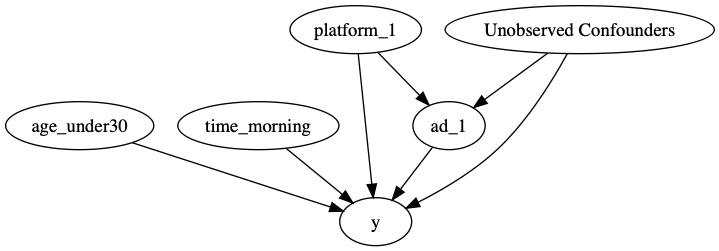

In [6]:
model = CausalModel(
        data = data,
        treatment='ad_1',
        outcome='y',
        graph="digraph {ad_1 -> y;\
        \
        age_under30 -> y;\
        time_morning -> y;\
        platform_1 -> ad_1;\
        \
        platform_1 -> y;}"
                )
model.view_model()

from IPython.display import Image, display
display(Image(filename="causal_model.png"))

### Identify

In [7]:
# Causal estimand
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['U', 'platform_1']


WARN: Do you want to continue by ignoring these unobserved confounders? [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                             
────(Expectation(y|platform_1))
dad₁                           
Estimand assumption 1, Unconfoundedness: If U→ad_1 and U→y then P(y|ad_1,platform_1,U) = P(y|ad_1,platform_1)
### Estimand : 2
Estimand name: iv
No such variable found!



### Estimate

In [8]:
# Matching
causal_estimate_match = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_matching")
print(causal_estimate_match)
print("Causal Estimate is " + str(causal_estimate_match.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: y~ad_1+platform_1


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                             
────(Expectation(y|platform_1))
dad₁                           
Estimand assumption 1, Unconfoundedness: If U→ad_1 and U→y then P(y|ad_1,platform_1,U) = P(y|ad_1,platform_1)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: y~ad_1+platform_1
## Estimate
Value: 0.7708333333333334

Causal Estimate is 0.7708333333333334


/Users/annapauxberger/anaconda/envs/py36/lib/python3.6/site-packages/dowhy/causal_estimators/propensity_score_matching_estimator.py:51: FutureWarning: `item` has been deprecated and will be removed in a future version
  control_outcome = control.iloc[indices[i]][self._outcome_name].item()


In [9]:
# Regression
causal_estimate_reg = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        test_significance=True)
print(causal_estimate_reg)
print("Causal Estimate is " + str(causal_estimate_reg.value))

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~ad_1+platform_1


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                             
────(Expectation(y|platform_1))
dad₁                           
Estimand assumption 1, Unconfoundedness: If U→ad_1 and U→y then P(y|ad_1,platform_1,U) = P(y|ad_1,platform_1)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: y~ad_1+platform_1
## Estimate
Value: 0.5825821519298531

## Statistical Significance
p-value: <0.001

Causal Estimate is 0.5825821519298531


### Refute

#### Matching

In [10]:
# Replacing treatment with a random (placebo) variable
res_placebo=model.refute_estimate(identified_estimand, causal_estimate_match,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: y~placebo+platform_1


Refute: Use a Placebo Treatment
Estimated effect:(0.7708333333333334,)
New effect:(-0.25,)



/Users/annapauxberger/anaconda/envs/py36/lib/python3.6/site-packages/dowhy/causal_estimators/propensity_score_matching_estimator.py:51: FutureWarning: `item` has been deprecated and will be removed in a future version
  control_outcome = control.iloc[indices[i]][self._outcome_name].item()


In [11]:
# Removing a random subset of the data
res_subset=model.refute_estimate(identified_estimand, causal_estimate_match,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: y~ad_1+platform_1
/Users/annapauxberger/anaconda/envs/py36/lib/python3.6/site-packages/dowhy/causal_estimators/propensity_score_matching_estimator.py:51: FutureWarning: `item` has been deprecated and will be removed in a future version
  control_outcome = control.iloc[indices[i]][self._outcome_name].item()


Refute: Use a subset of data
Estimated effect:(0.7708333333333334,)
New effect:(0.7857142857142857,)



In [12]:
# Add random seed

res_subset=model.refute_estimate(identified_estimand, causal_estimate_match,
        method_name="data_subset_refuter", subset_fraction=0.9, random_seed = 1)
print(res_subset)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: y~ad_1+platform_1
/Users/annapauxberger/anaconda/envs/py36/lib/python3.6/site-packages/dowhy/causal_estimators/propensity_score_matching_estimator.py:51: FutureWarning: `item` has been deprecated and will be removed in a future version
  control_outcome = control.iloc[indices[i]][self._outcome_name].item()


Refute: Use a subset of data
Estimated effect:(0.7708333333333334,)
New effect:(0.7380952380952381,)



#### Regression

In [13]:
# Replacing treatment with a random (placebo) variable
res_placebo=model.refute_estimate(identified_estimand, causal_estimate_reg,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+platform_1


Refute: Use a Placebo Treatment
Estimated effect:(0.5825821519298531,)
New effect:(-0.07599154746423933,)



In [14]:
# Removing a random subset of the data
res_subset=model.refute_estimate(identified_estimand, causal_estimate_reg,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~ad_1+platform_1


Refute: Use a subset of data
Estimated effect:(0.5825821519298531,)
New effect:(0.5393822393822396,)



In [15]:
# Add random seed

res_subset=model.refute_estimate(identified_estimand, causal_estimate_reg,
        method_name="data_subset_refuter", subset_fraction=0.9, random_seed = 1)
print(res_subset)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~ad_1+platform_1


Refute: Use a subset of data
Estimated effect:(0.5825821519298531,)
New effect:(0.5566807313642755,)

